<a href="https://colab.research.google.com/github/Penelopeeirini/Master-Thesis/blob/main/Deeptrack2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install deeptrack
import deeptrack as dt
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.2/190.2 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.0/292.0 kB 22.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 91.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 577.9/577.9 kB 38.8 MB/s eta 0:00:00
  Created wheel for pint: filename=Pint-0.19.2-py3-none-any.whl size=231001 sha256=e799f704e18abce5a6d162721e9d48d0d27d218290133137f9c33ef9b2c2a5c8
  Stored in directory: /root/.cache/pip/wheels/eb/00/87/c216aa83b91597845d9fec6fcd9dbe31c945a25d968dd4765a
Successfully built pint
  At

/usr/local/lib/python3.10/dist-packages/deeptrack/backend/_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/deeptrack/backend/_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [8]:
import matplotlib.pyplot as plt

In [9]:
IMAGE_SIZE=51
particle = dt.PointParticle(
position=lambda:np.random.uniform(
IMAGE_SIZE / 2 - 5,
IMAGE_SIZE / 2 + 5,
size=2,
),
)

In [10]:
optics = dt.Fluorescence(
output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),)

TRAIN EASIER THE NEURAL NETWORK

In [11]:
normalization = dt.NormalizeMinMax(0, 1)

SIMULATION PIPELINE

In [12]:
data_simulation = optics(particle) >> normalization
data = np.zeros((1000, IMAGE_SIZE, IMAGE_SIZE, 1))
ground_truth = np.zeros((1000, 2))

In [13]:
for i in range(1000):
  data_simulation.update()
  data[i] = data_simulation()
  ground_truth[i] = particle.position()


PARTICLE PLOTS


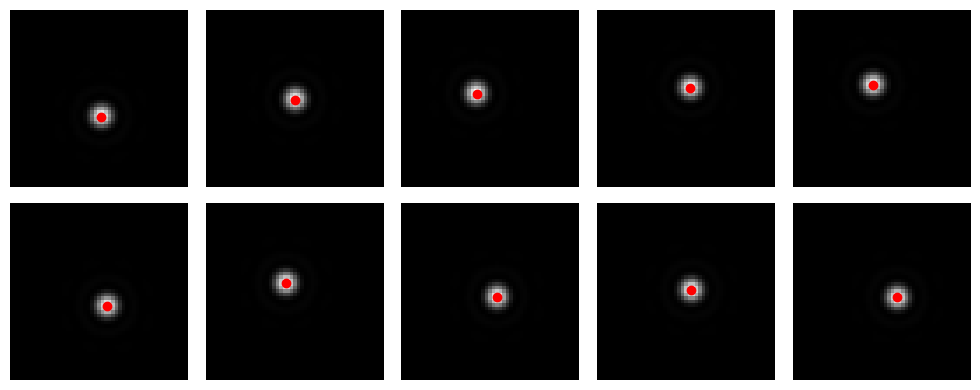

In [14]:
plt.figure(figsize=(10, 4))
for i in range(10):
  plt.subplot(2, 5, i + 1)
  plt.imshow(data[i, ..., 0], cmap="gray")
  plt.scatter(ground_truth[i, 1], ground_truth[i, 0], c="r")
  plt.axis("off")
  plt.tight_layout()
plt.show()

**Convolutional neural network**. This script defines a
convolutional neural network with a dense top that takes an image
as input and outputs the position of the object in the image.

In [15]:
model = dt.models.Convolutional(
input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
number_of_outputs=2,
)

In [16]:
import tensorflow.keras.backend as K

**Loss** **function**

In [17]:
def geometric_loss(transformation, prediction):
  de_transformed = prediction - transformation
  distance = K.std(de_transformed, axis=0)
  return distance
# transformation contains the translation applied to the images
# shape: (batch_size, 2)
# prediction contains the predicted position of the object in the images
# shape: (batch_size, 2)
model.compile(loss=geometric_loss, optimizer="adam")

In [18]:
def translation_function(translation):
  def translate_image(image):
    import scipy.ndimage as ndimage
    translated_image = ndimage.shift(
        image.squeeze(),
        translation,
        order=1,mode="reflect",
    )
    return translated_image[..., np.newaxis]
  return translate_image
translation_transformation = dt.Lambda(
    translation_function,
    translation=lambda:np.random.uniform(-5, 5, size=2),
)
def get_batch(data, batch_size=2):
  # data contains the anchor image
  # shape: (IMAGE_SIZE, IMAGE_SIZE, 1)
  output_data_buffer = np.zeros((batch_size, IMAGE_SIZE, IMAGE_SIZE, 1))
  output_label_buffer = np.zeros((batch_size, 2))
  for i in range(batch_size):
    translation_transformation.update()
    output_data_buffer[i] = translation_transformation(data)
    output_label_buffer[i] = translation_transformation.translation()
  return output_data_buffer, output_label_buffer

In [19]:
def train_epoch(images):
  # images contains the images to train on
  # shape: (N, IMAGE_SIZE, IMAGE_SIZE, 1)
  epoch_loss = 0
  for idx, anchor_image in enumerate(images):
    batch = get_batch(anchor_image)
    epoch_loss += model.train_on_batch(batch[0], batch[1])
  return epoch_loss / len(images)

In [20]:
training_data_size = 100
for epoch in range(20):
  print("Epoch: ", epoch)
  loss = train_epoch(data[:training_data_size])
  print("\nLoss: ", loss)

Epoch:  0

Loss:  0.9373386308550835
Epoch:  1

Loss:  0.3591306163743138
Epoch:  2

Loss:  0.3205562134832144
Epoch:  3

Loss:  0.2258524166047573
Epoch:  4

Loss:  0.33416575148701666
Epoch:  5

Loss:  0.19778350070118905
Epoch:  6

Loss:  0.24414373457431793
Epoch:  7

Loss:  0.22214438159251584
Epoch:  8

Loss:  0.16882580474019052
Epoch:  9

Loss:  0.18974414587020874
Epoch:  10

Loss:  0.17870426252484323
Epoch:  11

Loss:  0.13386480033397674
Epoch:  12

Loss:  0.1145133751630783
Epoch:  13

Loss:  0.12960797818377615
Epoch:  14

Loss:  0.13290423452854155
Epoch:  15

Loss:  0.14012147277593612
Epoch:  16

Loss:  0.15433836072683335
Epoch:  17

Loss:  0.12794606134295464
Epoch:  18

Loss:  0.12461462914943695
Epoch:  19

Loss:  0.14478028895216993


29/29 [==============================] - 1s 30ms/step


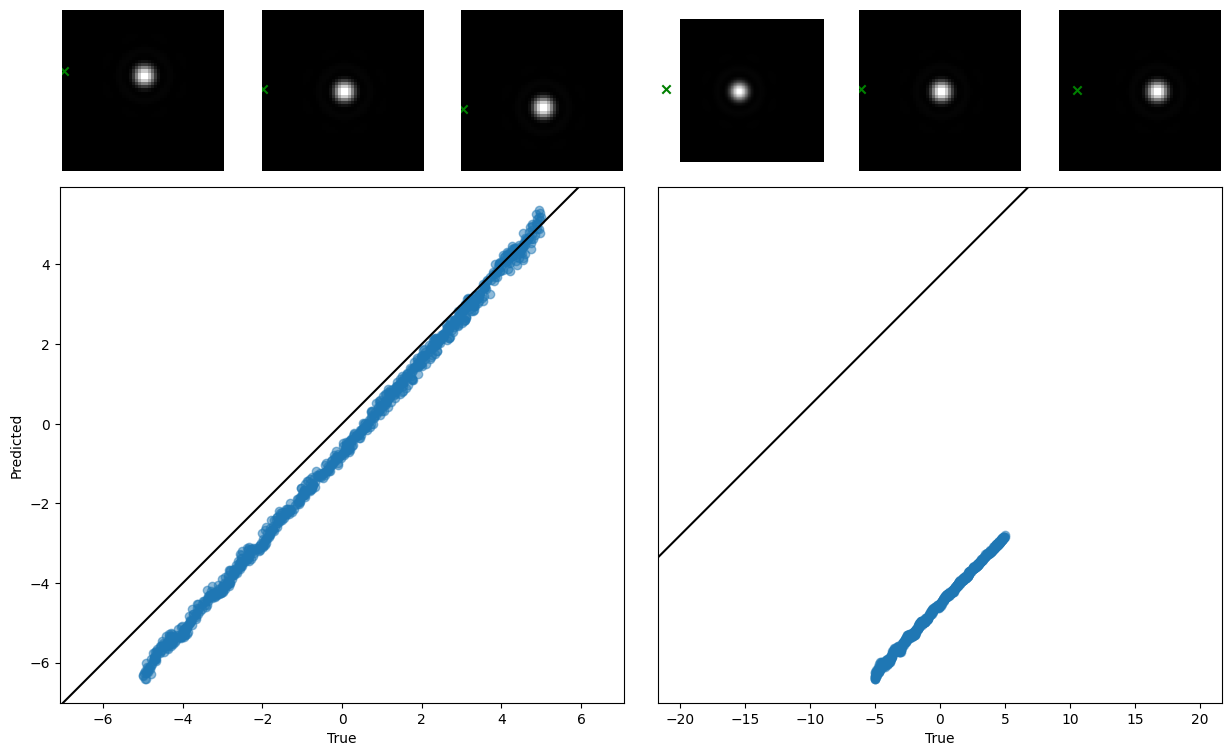

In [21]:
predictions = model.predict(data[training_data_size:])
gt = ground_truth[training_data_size:] - IMAGE_SIZE / 2
plt.figure(figsize=(15, 9))
grid = plt.GridSpec(4, 6, wspace=0.2, hspace=0.1)

plt.subplot(grid[1:, : 3])
plt.scatter(
    gt[:, 0],
    predictions[:, 0],
    alpha=0.5,
)
plt.axline((-5, -5), (5, 5), color="black")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.axis("equal")

plt.subplot(grid[1:, 3:])
plt.scatter(
    gt[:, 1],
    predictions[:, 1],
    alpha=0.5,
)
plt.axline((-5, -5), (5, 5), color="black")
plt.xlabel("True")
plt.axis("equal")
plt.yticks([])

for idx, offset in enumerate(np.linspace(-5, 5, 3)):
  # Create new data at specific offsets
  image_offset_x = data_simulation(position=(IMAGE_SIZE / 2 + offset,
                                             IMAGE_SIZE / 2))
  image_offset_y = data_simulation(position=(IMAGE_SIZE / 2, IMAGE_SIZE /
                                             2 + offset))
  predicted_positions = model.predict_on_batch(np.array([image_offset_x,
                                                         image_offset_y]))
  plt.subplot(grid[0, idx])
  plt.imshow(image_offset_x, cmap="gray")
  plt.scatter(
      IMAGE_SIZE / 2 + predicted_positions[0, 1],
      IMAGE_SIZE / 2 + predicted_positions[0, 0],
      color="g",
      marker="x"
  )
  plt.axis("off")
  plt.subplot(grid[0, 3 + idx])
  plt.imshow(image_offset_y, cmap="gray")
  plt.scatter(
    IMAGE_SIZE / 2 + predicted_positions[1, 1],
    IMAGE_SIZE / 2 + predicted_positions[1, 0],
    color="g",
    marker="x"
  )
  plt.axis("off")

plt.show()


### **LODESTAR**
Creating a LodeSTAR network


In [22]:
model = dt.models.LodeSTAR(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
)

model.compile(
    optimizer="adam",
    loss="mae"
)

Creating a pipeline for LodeSTAR




In [23]:
training_data_size = 100
random_image = dt.Value(
    image_index= lambda: np.random.randint(0, training_data_size),
    value=lambda image_index: data[image_index]
)

Training LodeSTAR

In [ ]:
model.fit(
    random_image,
    epochs=100,
    batch_size=8,
    steps_per_epoch=100,
)

Generating 167 / 160 samples before starting training
Epoch 1/100
100/100 [==============================] - 57s 476ms/step - total_loss: 1.5943 - consistency_loss: 0.8814
Epoch 2/100
100/100 [==============================] - 59s 591ms/step - total_loss: 0.0911 - consistency_loss: 0.0153
Epoch 3/100
100/100 [==============================] - 41s 413ms/step - total_loss: 0.0590 - consistency_loss: 0.0092
Epoch 4/100
100/100 [==============================] - 33s 329ms/step - total_loss: 0.0457 - consistency_loss: 0.0069
Epoch 5/100
100/100 [==============================] - 61s 611ms/step - total_loss: 0.0521 - consistency_loss: 0.0061
Epoch 6/100
100/100 [==============================] - 59s 590ms/step - total_loss: 0.0394 - consistency_loss: 0.0064
Epoch 7/100
100/100 [==============================] - 43s 421ms/step - total_loss: 0.0475 - consistency_loss: 0.0055
Epoch 8/100
100/100 [==============================] - 61s 607ms/step - total_loss: 0.0460 - consistency_loss: 0.0054
Ep

In [ ]:
predictions = model.predict_and_pool(data[training_data_size:]) -
  IMAGE_SIZE /2
gt = ground_truth[training_data_size:] - IMAGE_SIZE / 2